Aim: reconstruct the model fitted to one (or all) of the time series, and draw

In [38]:
%matplotlib inline

In [2]:
# Getting the cell objects with the time series and AR stuff
# Just doing this for the 2020-02-07 dataset for the time being

import numpy as np
import scipy as sp
import pandas as pd
import itertools
import matplotlib.pyplot as plt

import pipeline.dataimport
import pipeline.periodogram
import pipeline.tsman
import pipeline.vis

working_directory = './data/arin/'

# Import information for flavin exposure experiment from files
Flavin_rawdata = pipeline.dataimport.import_timeseries( \
        working_directory+'Flavinexpostest3_ffcorr_small.csv')
Flavin_dcategory = pipeline.dataimport.import_categories( \
        working_directory+'Flavinexpostest3_ffcorr_small_OscillationEvals.txt')
Flavin_births = pipeline.dataimport.import_births( \
        working_directory+'Flavinexpostest3_ffcorr_small_births.csv')

# Arranges information into DatasetAttr objects
Flavin_data = pipeline.dataimport.CellAttr_from_datasets( \
        timeseries_df = Flavin_rawdata,
        categories_array = Flavin_dcategory,
        births_df = Flavin_births)
Flavin = pipeline.DatasetAttr(Flavin_data)

# Add just the labels so as not to break things
for ii, cell in enumerate(Flavin.cells):
    cell.flavin.reading = cell.y
    cell.flavin.category = Flavin_dcategory[ii]
    
def add_classicalAttr(cell, oversampling_factor = 1):
    """Computes classical periodogram and adds PdgramAttr attributes"""
    cell.flavin.classical.freqs, cell.flavin.classical.power = \
            pipeline.periodogram.classical(cell.time, cell.flavin.reading_processed,
                                oversampling_factor = oversampling_factor)

def add_autoregAttr(cell):
    """
    Computes autoregressive model-based periodogram and adds PdgramAttr
    attributes
    """
    cell.flavin.autoreg = pipeline.PdgramAttr()
    cell.flavin.autoreg.label = \
            'Autogressive Model-Based Periodogram (Jia & Grima, 2020)'
    cell.flavin.autoreg.power_label = 'Power'
    freq_npoints = 1000
    cell.flavin.autoreg.freqs, cell.flavin.autoreg.power = \
            pipeline.periodogram.autoreg(cell.time,
                                         cell.flavin.reading_processed,
                                         freq_npoints)
for cell in Flavin.cells:
    cell.flavin.reading_processed = \
        pipeline.tsman.stdfilter(cell.flavin.reading, Fs = 1/2.5)

pipeline.tsman.population_detrend(Flavin.cells, 'flavin.reading_processed')

for cell in [Flavin.cells[72], Flavin.cells[202]]:
    # Fourier
    add_classicalAttr(cell, oversampling_factor = 1)
    # AR
    add_autoregAttr(cell)
    print(cell.cellid)

72
202


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Autofluorescence of cell 72 over time'}, xlabel='Time (min)', ylabel='Autofluorescence (AU)'>)

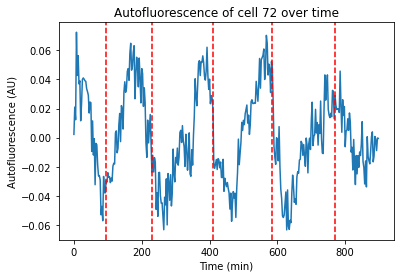

In [98]:
cell_index = 72
Flavin.cells[cell_index].plot_ts(y_attr='flavin.reading_processed')

In [99]:
# Fitting and estimating parameters
timeseries = Flavin.cells[cell_index].flavin.reading_processed
timeaxis = Flavin.cells[cell_index].time

from pipeline.ar_grima2020 import AR_Fit, AR_Power, optimise_ar_order

optimal_ar_order = optimise_ar_order(timeseries, int(3*np.sqrt(len(timeseries))))
print(f'Optimal AR order: {optimal_ar_order}')

model = AR_Fit(timeseries, optimal_ar_order)
print(f"Mean: {model.mean}")
print(f"Length of timeseries: {model.length}")
print(f"First element: {model.timeseries[0]}")
print(f"Autocorrelation function coefficients (R):\n {model.sample_acfs}")
print(f"Autoregression coefficients (phi):\n {model.ar_coeffs}")
print(f"Noise parameter: {model.noise_param}")

Optimal AR order: 22
Mean: 0.0010568487203326657
Length of timeseries: 360
First element: 0.0022312173123178723
Autocorrelation function coefficients (R):
 [ 9.61447820e-04  8.55722744e-04  8.21471791e-04  7.95363575e-04
  7.60857862e-04  7.13077916e-04  6.86538443e-04  6.47982512e-04
  5.83535391e-04  5.36590598e-04  4.77090463e-04  4.19062374e-04
  3.41715988e-04  2.81158308e-04  2.18561143e-04  1.50879988e-04
  9.67256160e-05  2.71162630e-05 -3.51979372e-05 -9.82382851e-05
 -1.67128357e-04 -1.97816158e-04 -2.66056054e-04]
Autoregression coefficients (phi):
 [ 1.          0.55104129  0.14476153  0.12875415  0.09143882 -0.09791543
  0.1484103   0.0771666  -0.08221027  0.07012176 -0.06308431  0.08868735
 -0.13253016 -0.00502249 -0.00719888 -0.06058508  0.11558083 -0.0769458
 -0.00927717  0.01893387 -0.17058381  0.2274755  -0.14074156]
Noise parameter: 0.00014911850270778052


In [100]:
# Checks if phi values satisfies unit circle condition
from numpy.polynomial import Polynomial
phi_polynomial = Polynomial(model.ar_coeffs)
print(f"Complex roots:\n {phi_polynomial.roots()}")
print(f"Absolute values:\n {np.abs(phi_polynomial.roots())}")

Complex roots:
 [-0.99763132+0.j         -0.99450229-0.28902264j -0.99450229+0.28902264j
 -0.80088028-0.52039553j -0.80088028+0.52039553j -0.6555163 -0.79932053j
 -0.6555163 +0.79932053j -0.40851213-1.00406532j -0.40851213+1.00406532j
 -0.08988456-1.06426183j -0.08988456+1.06426183j  0.17718661-1.06446947j
  0.17718661+1.06446947j  0.53447892-0.9794959j   0.53447892+0.9794959j
  0.84946914-0.89557049j  0.84946914+0.89557049j  0.98349483-0.64908823j
  0.98349483+0.64908823j  1.132911  -0.38457408j  1.132911  +0.38457408j
  1.15740533+0.j        ]
Absolute values:
 [0.99763132 1.03564901 1.03564901 0.95510247 0.95510247 1.03373832
 1.03373832 1.08398769 1.08398769 1.06805079 1.06805079 1.07911554
 1.07911554 1.1158315  1.1158315  1.23435988 1.23435988 1.17837923
 1.17837923 1.19640484 1.19640484 1.15740533]


In [101]:
# Compute model time series (reverse-engineering from parameters)
timeseries_modelled = np.empty(model.length)
for index in range(model.length):
    if index < optimal_ar_order:
        timeseries_modelled[index] = timeseries[index]
    else:
        preceding_points = timeseries[index-optimal_ar_order:index]
        linear_combination = np.dot(model.ar_coeffs[1::], preceding_points[::-1])
        timeseries_modelled[index] = linear_combination

In [89]:
model.ar_coeffs[0]

1.0

Text(0, 0.5, 'Fluorescence (AU)')

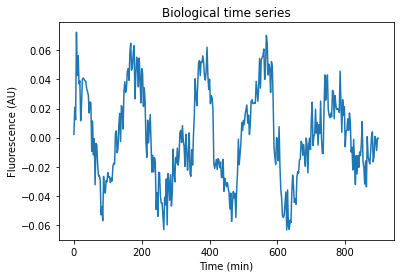

In [102]:
# Time series
plt.plot(timeaxis, timeseries)
plt.title('Biological time series')
plt.xlabel('Time (min)')
plt.ylabel('Fluorescence (AU)')

Text(0, 0.5, 'Fluorescence (AU)')

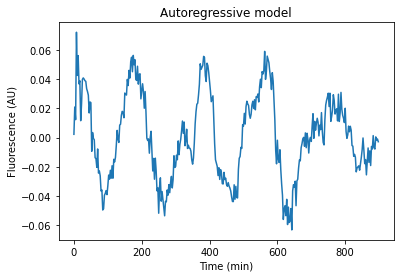

In [103]:
# Model
plt.plot(timeaxis, timeseries_modelled)
plt.title('Autoregressive model')
plt.xlabel('Time (min)')
plt.ylabel('Fluorescence (AU)')

Text(0, 0.5, 'Fluorescence (AU)')

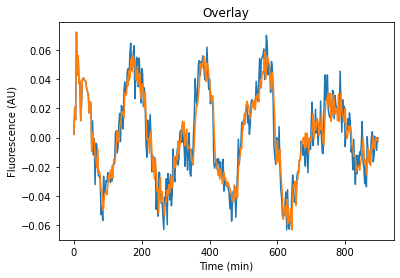

In [104]:
# Overlay
plt.plot(timeaxis, timeseries)
plt.plot(timeaxis, timeseries_modelled)
plt.title('Overlay')
plt.xlabel('Time (min)')
plt.ylabel('Fluorescence (AU)')

Comments
- Not all phi values satisfy the unit circle condition, but it could just be the result of numerical method upon numerical method; the absolute values are quite close to 1 anyway.
- Do I have to take the first n time points, or can I grab something somewhere in the middle?  It will definitely produce a different output, but will the frequency change?
- Definitely a great way to smooth out the time series.
- Is the order related to quality by any chance??

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Periodogram (spectrum)'}, xlabel='Frequency ($min^{-1}$)', ylabel='Power (dimensionless)'>)

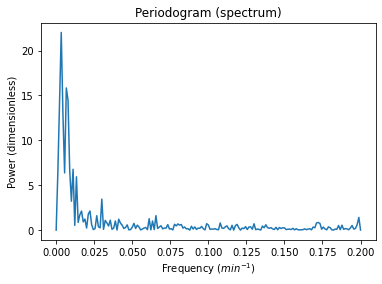

In [93]:
Flavin.cells[cell_index].flavin.plot_ps(pdgram='classical')

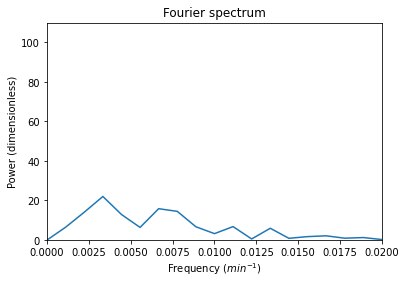

In [94]:
fig, ax = plt.subplots()
ax.plot(Flavin.cells[cell_index].flavin.classical.freqs,
       Flavin.cells[cell_index].flavin.classical.power)
ax.set_xlim([0,0.02])
ax.set_ylim([0,110])
ax.set_xlabel('Frequency ($min^{-1}$)')
ax.set_ylabel('Power (dimensionless)')
ax.set_title('Fourier spectrum')
plt.show()

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Autogressive Model-Based Periodogram (Jia & Grima, 2020)'}, xlabel='Frequency ($min^{-1}$)', ylabel='Power'>)

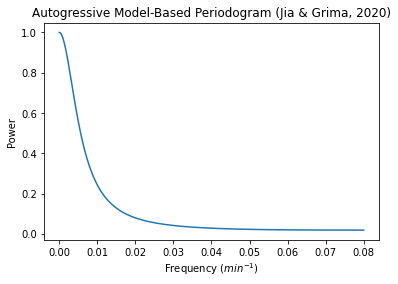

In [95]:
Flavin.cells[cell_index].flavin.plot_ps(pdgram='autoreg')

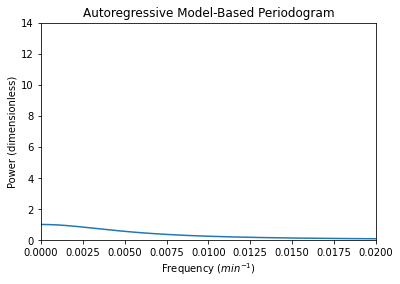

In [96]:
fig, ax = plt.subplots()
ax.plot(Flavin.cells[cell_index].flavin.autoreg.freqs,
       Flavin.cells[cell_index].flavin.autoreg.power)
ax.set_xlim([0,0.02])
ax.set_ylim([0,14])
ax.set_xlabel('Frequency ($min^{-1}$)')
ax.set_ylabel('Power (dimensionless)')
ax.set_title('Autoregressive Model-Based Periodogram')
plt.show()

In [97]:
c = max(Flavin.cells[cell_index].flavin.classical.power)
a = max(Flavin.cells[cell_index].flavin.autoreg.power)
print(c)
print(a)
print(c/a)

22.019471372219606
1.0
22.019471372219606
